# Analysis & Program File

In [2]:
# import pandas as pd
# import numpy as np

# url = 'https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Electronics_v1_00.tsv.gz'
# url_data = pd.read_table(url, sep='\t', nrows=809815, error_bad_lines=False)
# url_data.to_csv('electronics_raw_data.csv', index=False)

b'Skipping line 9076: expected 15 fields, saw 22\nSkipping line 19256: expected 15 fields, saw 22\nSkipping line 24313: expected 15 fields, saw 22\nSkipping line 47211: expected 15 fields, saw 22\nSkipping line 54295: expected 15 fields, saw 22\nSkipping line 56641: expected 15 fields, saw 22\nSkipping line 63067: expected 15 fields, saw 22\n'
b'Skipping line 93796: expected 15 fields, saw 22\n'
b'Skipping line 132806: expected 15 fields, saw 22\nSkipping line 164631: expected 15 fields, saw 22\nSkipping line 167019: expected 15 fields, saw 22\nSkipping line 167212: expected 15 fields, saw 22\n'
b'Skipping line 198103: expected 15 fields, saw 22\nSkipping line 199191: expected 15 fields, saw 22\nSkipping line 202841: expected 15 fields, saw 22\nSkipping line 218228: expected 15 fields, saw 22\nSkipping line 235900: expected 15 fields, saw 22\n'
b'Skipping line 277761: expected 15 fields, saw 22\nSkipping line 304582: expected 15 fields, saw 22\nSkipping line 312029: expected 15 fields,

### Call Saved, Cleaned Raw Data

In [ ]:
import pandas as pd
import numpy as np

with open('electronics_raw_data.csv', encoding='utf-8') as fp:
    df = pd.read_csv(fp)

### Sentiment Analysis Functions

In [3]:
def get_nrc_data():
    nrc_bigram = "Amazon-laptops-electronics-reviews-AFFLEX-NEGLEX-bigrams.txt"
    nrc_unigram = "Amazon-laptops-electronics-reviews-AFFLEX-NEGLEX-unigrams.txt"
    nrc_emotion = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
  
    unigram_dict=dict()
    bigram_dict=dict()
    emotion_dict=dict()
    
    with open(nrc_bigram, 'r', encoding='utf-8') as b:
        for line in b:
            line = line.strip().split('\t')
            bigram_dict[line[0]] = float(line[1])
                    
    with open(nrc_unigram, 'r', encoding='utf-8') as u:
        for line in u:
            line = line.strip().split('\t')
            unigram_dict[line[0]] = float(line[1])
    
    with open(nrc_emotion, 'r', encoding='utf-8') as f:
        count=0
        for line in f:
            if count < 46:
                count+=1
                continue
            line = line.strip().split('\t')
            if int(line[2]) == 1:
                if emotion_dict.get(line[0]):
                    emotion_dict[line[0]].append(line[1])
                else:
                    emotion_dict[line[0]] = [line[1]]
    
    return unigram_dict,bigram_dict, emotion_dict

In [4]:
unigram_dict, bigram_dict, emotion_dict = get_nrc_data()

In [5]:
def pos_neg_analyzer(text, unigram_dict=unigram_dict, bigram_dict=bigram_dict):
    total_words = (len(text.split())*2)-1
    paragraph = text.lower().split()
    pos_count = 0
    neg_count = 0
    score = 0
    for x in range(len(paragraph)):
        unigram = paragraph[x]
        if unigram in unigram_dict.keys():
            score += float(unigram_dict[unigram])
            if unigram_dict[unigram] > 0:
                pos_count += 1
            elif unigram_dict[unigram] < 0:
                neg_count += 1
        
        if x < len(paragraph)-1:
            bigram = ' '.join([paragraph[x],paragraph[x+1]])
            if bigram in bigram_dict.keys():
                score += float(bigram_dict[bigram])
                if bigram_dict[bigram] > 0:
                    pos_count += 1
                elif bigram_dict[bigram] < 0:
                    neg_count += 1
    
    pos_perc = pos_count/total_words
    neg_perc = neg_count/total_words
    return score, pos_perc, neg_perc        

In [6]:
def get_complexity(text):
    
    from nltk.tokenize import word_tokenize, sent_tokenize
    
    num_chars=len(text)
    num_words=len(word_tokenize(text))
    num_sentences=len(sent_tokenize(text))
    vocab = {x.lower() for x in word_tokenize(text)}
    
    if num_words == 0 or num_sentences == 0:
        char_per_word = 0
        word_per_sent = 0
        unique_word_perc = 0
    else:
        char_per_word = float(num_chars/num_words)
        word_per_sent = float(num_words/num_sentences)
        unique_word_perc = len(vocab)/num_words
    
    return num_words, char_per_word, word_per_sent, unique_word_perc

In [7]:
def emotion_analyzer(text, emotion_dict=emotion_dict):
    emotions = {x for y in emotion_dict.values() for x in y}
    emotion_count = dict()
    for emotion in emotions:
        emotion_count[emotion] = 0
    
    total_words = len(text.split())
    for word in text.lower().split():
        if emotion_dict.get(word):
            for emotion in emotion_dict.get(word):
                emotion_count[emotion] += 1/len(text.split())
                
    return emotion_count

In [8]:
def review_emotion_analyzer(text_tuples,object_name="Product Name"):
    
    import pandas as pd
    df = pd.DataFrame(columns=[object_name,'Fear','Trust','Negative',
                           'Positive','Joy','Disgust','Anticipation',
                           'Sadness','Surprise'],)
    df.set_index(object_name,inplace=True)
    
    output = df    
    for text_tuple in text_tuples:
        text = text_tuple[1] 
        result = emotion_analyzer(text)
        df.loc[text_tuple[0]] = [result['fear'],result['trust'],
                  result['negative'],result['positive'],result['joy'],result['disgust'],
                  result['anticipation'],result['sadness'],result['surprise']]
    return output

# Review Analysis

In [38]:
url_product = df.set_index('product_title')
url_product.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
product_title,,,,,,,,,,,,,,
yoomall 5M Antenna WIFI RP-SMA Female to Male Extensionl Cable,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",US,49668221,R2HBOEM8LE9928,B000068O48,734576678,Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
Channel Master Titan 2 Antenna Preamplifier,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
LIMTECH Wall charger + USB Hotsync & Charging Dock Cradle desktop Charger for Apple IPOD Shuffle 2nd Generation MP3 Player,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
Skullcandy Air Raid Portable Bluetooth Speaker,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


### Getting Top Reviews

In [39]:
# Aggregate review of unique product_title
review_df = url_product.groupby('product_title')['review_body'].apply(lambda x: list(x.dropna())).reset_index()

In [71]:
# Select top positive and top critical review for each product if review count is sufficient
def select_top_review(review_df)
    ovr_review_body_list = review_df['review_body'].tolist()
    ovr_pos_review_list = []
    ovr_neg_review_list = []
    for x in ovr_review_body_list:
        if len(x) <= 10:
            ovr_pos_review_list.append('Not enough reviews')
            ovr_neg_review_list.append('Not enough reviews')
        else:
            x = '||'.join(x)
            ovr_score, ovr_pos_perc, ovr_neg_perc = pos_neg_analyzer(x)
            ovr_num_words, ovr_char_per_word, ovr_word_per_sent, ovr_unique_word_perc = get_complexity(x)
            prod_review_body = x.split('||')

            pos_composite_score = 0
            neg_composite_score = 0
            top_positive_review = ''
            top_critical_review = ''

            for y in prod_review_body:
                review_score = 0
                score, pos_perc, neg_perc = pos_neg_analyzer(y)
                num_words, char_per_word, word_per_sent, unique_word_perc = get_complexity(y)
                review_score = (num_words/ovr_num_words) + (char_per_word/ovr_char_per_word)
                + (word_per_sent/ovr_word_per_sent) + (unique_word_perc/ovr_unique_word_perc)
                if pos_perc > (ovr_pos_perc/len(prod_review_body)) and score > (ovr_score/len(prod_review_body)):
                    if review_score > pos_composite_score:
                        top_positive_review = y
                        pos_composite_score = review_score
                if neg_perc > (ovr_neg_perc/len(prod_review_body)) and score < 0:
                    if review_score > neg_composite_score:
                        top_critical_review = y
                        neg_composite_score = review_score

            if not top_positive_review:
                top_positive_review = 'None Available'
            if not top_critical_review:
                top_critical_review = 'None Available'
            ovr_pos_review_list.append(top_positive_review)
            ovr_neg_review_list.append(top_critical_review)
    
    return ovr_pos_review_list, ovr_neg_review_list

In [44]:
# Input top review data onto the aggregated review dataframe
review_df['Top Positive Review'] = np.nan
review_df['Top Critical Review'] = np.nan
pos_review_list, neg_review_list = select_top_review(review_df)
review_df['Top Positive Review'] = pd.Series(ovr_pos_review_list)
review_df['Top Critical Review'] = pd.Series(ovr_neg_review_list)

In [43]:
review_df.head()

,product_title,review_body,Top Positive Review,Top Critical Review
0,Model A RBX10 Programmable End Of Transmissi...,['Very nice roger beep and easy Ty install'],Not enough reviews,Not enough reviews
1,#1 BEST SELLING Waterproof Bluetooth Speaker w...,"[""I love it! I paid $200 for a Beats Pill when...",Let me start off by saying I love music. All t...,Speakers sounded great...happy with size and c...
2,#1 Best Auxiliary Audio Cable With Top-Notch S...,"[""I purchased 10 of these components for a pro...",This cable was delivered quickly and in perfec...,I purchased 10 of these components for a proje...
3,"#1 Best Bluetooth Shower Speaker, 100% Waterpr...",['Joshal Products made a good bluetooth speake...,I recently tried a Mooietech shower speaker an...,Simply not loud enough
4,#1 Cable Organizer Coiled Tube Sleeve Cable-GV...,['This is an incredibly poorly manufactured kn...,Not enough reviews,Not enough reviews


Obtaining top positive and negative review takes a long time. Therefore, we saved the file as .csv to save time for future runs

In [121]:
review_df.to_csv('review_raw_data.csv', index=False)

### EDA & Statistical Analysis

Looking at most relevant review keywords people used for product (i.e. speakers)

In [54]:
speaker_df = search_item_raw('speaker')

In [55]:
speakers_review = speaker_df['review_body'].astype(str).tolist()
text = ' '.join(speakers_review)

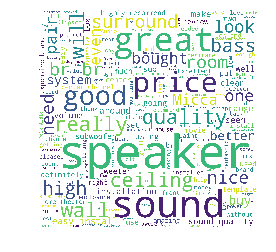

In [143]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=6000, height=6000).generate(text)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [68]:
from nltk import word_tokenize
word_list = word_tokenize(text.lower())

In [69]:
from collections import Counter
Counter = Counter(word_list)
most_occur = Counter.most_common()

In [83]:
from nltk.corpus import stopwords
cleaned_freq_words = []
remove_words = ['I','br','the', 'great', 'good', 'it', 'one', 'use', 'would', 'like', 'speaker', 'speakers', 'love', 'well', 'really', 'get']
count = 0
for x in most_occur:
    if count < 10:
        if x[0] not in stopwords.words() and x[0].isalpha() and x[0] not in remove_words:
            cleaned_freq_words.append(x)
            count += 1

In [91]:
cleaned_freq_words

[('sound', 28908),
 ('quality', 8942),
 ('bluetooth', 7743),
 ('price', 6901),
 ('music', 6554),
 ('product', 6130),
 ('little', 6054),
 ('volume', 5842),
 ('bass', 5547),
 ('small', 5170)]

### Chi-Square Testing

In [130]:
freq_word_calc_rating = dict()
freq_word_orig_rating = dict()
for x in cleaned_freq_words:
    calc_rating = 0
    speaker_df = search_item_raw('speaker', x[0])
    rating = speaker_df['Rating'][1]
    speakers_review = speaker_df['review_body'].values
    text = speakers_review.astype(str)[0]
    sp_score, sp_pos_perc, sp_neg_perc = pos_neg_analyzer(text)
    split_text = text.split()
    word_count = len(split_text)
    calc_rating = ((sp_score/word_count) + 5)/2
    freq_word_calc_rating[x[0]] = calc_rating
    freq_word_orig_rating[x[0]] = rating

In [140]:
# Chi Squared Test
calc_rating_list = list(freq_word_calc_rating.values())
orig_rating_list = list(freq_word_orig_rating.values())

from scipy.stats import chisquare
chisquare(calc_rating_list, orig_rating_list)

Power_divergenceResult(statistic=9.015274320598884, pvalue=0.4358654287065382)

###### Chi Square Testing
###### Expected values: rating based on review star_rating
###### Observed values: rating based on our calculated score
###### p-value result: 0.436
###### Therefore, we fail to reject the null hypothesis test

### Functions used for statistical analysis

In [144]:
def get_raw_agg_chart(df, item_per_page_number=1):
    filtered_df = df.groupby('product_title')['star_rating'].agg(['mean', 'count'])
    filtered_df.columns = ['Rating', '# Of Reviews']
    weighted_rank(filtered_df)
    filtered_df = filtered_df[['Rating', '# Of Reviews', 'Rank']].sort_values('Rank', ascending=True)
    filtered_df = filtered_df.reset_index()
    filtered_df = filtered_df.join(review_df.set_index('product_title'), on='product_title')
    filtered_df = filtered_df.round({'Rating': 2})
    filtered_df.columns = ['Product Name', 'Rating', '# Of Reviews', 'Rank', 'review_body', 'Top Positive Review', 'Top Critical Review']
    filtered_df = filtered_df.set_index('Rank').head(n=item_per_page_number)
    
    return filtered_df

In [145]:
def search_item_raw(user_search_term, user_review_term=''):
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    import difflib
    
    #Get tokenized search term to check for in product name
    words = word_tokenize(user_search_term)
    words_list = [word for word in words
                      if word not in stopwords.words()]
    search = '|'.join(words_list)
    
    #Filter out peripheral products from search query
    peripheral_terms = ['cable', 'cord', 'case', 'cover', 'sleeve', 'mount', 'stand', 'wire',
                        'cloth', 'battery', 'holder', 'lens', 'adapter', 'replacement']
   
    for x in words_list:
        match = difflib.get_close_matches(x, peripheral_terms, n=1, cutoff=0.85)
        if match:
            peripheral_terms.remove(match[0])
    peripheral_search = '|'.join(peripheral_terms)
    
    #Search filtered query from database
    if user_review_term:
        search_df = url_product[url_product.index.str.contains(search, na=False, case=False)
                           & ~url_product.index.str.contains(peripheral_search, na=False, case=False)
                            & url_product['review_body'].str.contains(user_review_term, na=False, case=False)]
    else:
        search_df = url_product[url_product.index.str.contains(search, na=False, case=False)
                           & ~url_product.index.str.contains(peripheral_search, na=False, case=False)]
        
    return get_raw_agg_chart(search_df)

# Program

In [10]:
import pandas as pd
with open('C:\\Columbia\\FL2018\\DASource\\review_raw_data.csv', encoding='utf-8') as fp:
    review_df = pd.read_csv(fp)

In [11]:
def weighted_rank(df):
    total_count = df['# Of Reviews'].count()
    threshold = df['# Of Reviews'].mean() + df['# Of Reviews'].std()
    df['count_rank'] = df['# Of Reviews'].rank(ascending=False)
    df['rating_rank'] = df['Rating'].rank(ascending=False)
    df['rank_score'] = np.where(df['# Of Reviews'] >= threshold,
                                       df['Rating']/5 + (total_count-df['count_rank'])/total_count,
                                       (df['Rating']/5 + ((1-((threshold-df['# Of Reviews'])/threshold))*(total_count-df['count_rank'])/total_count)))
    df['Rank'] = df['rank_score'].rank(ascending=False).astype(int)

In [30]:
def get_filtered_chart(df, item_per_page_number=10):
    filtered_df = df.groupby('product_title')['star_rating'].agg(['mean', 'count'])
    filtered_df.columns = ['Rating', '# Of Reviews']
    weighted_rank(filtered_df)
    filtered_df = filtered_df[['Rating', '# Of Reviews', 'Rank']].sort_values('Rank', ascending=True)
    filtered_df = filtered_df.reset_index()
    filtered_df = filtered_df.join(review_df.set_index('product_title'), on='product_title')
    filtered_df = filtered_df.round({'Rating': 2})
    filtered_df = filtered_df[['product_title', 'Rating', '# Of Reviews', 'Rank', 'Top Positive Review', 'Top Critical Review']]
    filtered_df.columns = ['Product Name', 'Rating', '# Of Reviews', 'Rank', 'Top Positive Review', 'Top Critical Review']
    filtered_df = filtered_df.set_index('Rank').head(n=item_per_page_number)
    
    return filtered_df

In [27]:
def search_item(user_search_term, user_review_term = '', item_per_page_number=10):
    
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    import difflib
    
    #Get tokenized search term to check for in product name
    words = word_tokenize(user_search_term)
    words_list = [word for word in words
                      if word not in stopwords.words()]
    search = '|'.join(words_list)
    
    #Filter out peripheral products from search query
    peripheral_terms = ['cable', 'cord', 'case', 'cover', 'sleeve', 'mount', 'stand', 'wire',
                        'cloth', 'battery', 'holder', 'lens', 'adapter', 'replacement']
   
    for x in words_list:
        match = difflib.get_close_matches(x, peripheral_terms, n=1, cutoff=0.85)
        if match:
            peripheral_terms.remove(match[0])
    peripheral_search = '|'.join(peripheral_terms)
    
    #Search filtered query from database
    if user_review_term:
        search_df = url_product[url_product.index.str.contains(search, na=False, case=False)
                           & ~url_product.index.str.contains(peripheral_search, na=False, case=False)
                            & url_product['review_body'].str.contains(user_review_term, na=False, case=False)]
    else:
        search_df = url_product[url_product.index.str.contains(search, na=False, case=False)
                           & ~url_product.index.str.contains(peripheral_search, na=False, case=False)]
                        
    return get_filtered_chart(search_df, item_per_page_number)
        

In [33]:
search_item('headphone')

,Product Name,Rating,# Of Reviews,Top Positive Review,Top Critical Review
Rank,,,,,
1,Swimbuds SPORT Waterproof Headphones - See bel...,4.83,274,The waterproof shuffle and earplugs are a grea...,Great product to alleviate boredom of lap swim...
2,Sony MDR-V6 Monitor Series Headphones with CCA...,4.61,290,I have had these headphones for over a year an...,Item as described! cvpnj.com
3,Sennheiser Headphones,4.54,1007,These ARE beautiful sounding headphones with t...,Plug damaged
4,V-MODA XL-GREY Memory Cushions for Over-Ear He...,4.61,176,Amazingly comfortable definitely worth 20$ and...,Comfy. Slightly painful to change. At $20 good...
5,Skullcandy Crusher Headphones with Mic,4.58,231,They sound great work perfectly and are easy t...,Just as the description said
6,V-MODA Crossfade M-100 Over-Ear Noise-Isolatin...,4.55,271,Best headphones ever. If you are looking for ...,Glorious
7,Bose SoundLink On-Ear Bluetooth Headphones - B...,4.50,343,LOVE these headphones. A very indulgent purcha...,Don't have noise cancelation
8,Symphonized Wraith Headphones,4.50,310,"Without a doubt, the most accurate natural sou...",It will suffice
9,Bose QuietComfort 20 Headphones,4.46,580,The noise cancelling feature works well. If l...,Beast product


### GUI

In [31]:
from tkinter import *
from PIL import ImageTk, Image
from pandastable import Table, TableModel

class search():

    def __init__(self):

        root = Toplevel()
        root.lift()
        root.attributes("-topmost", True)
        root.geometry("1080x800")
        root.title("Amazeng")
        self.root = root

        # Build GUI
        canvas_width = 1080
        canvas_height = 800
        canvas = Canvas(root, height=canvas_height, width=canvas_width)
        self.canvas = canvas

        # Insert logo on top
        self.logo_frame = Frame(root, width=canvas_width, height=150)
        self.logo_frame.pack(fill=X,expand=True)

        logo_file = Image.open('main_logo_nobackground.png')
        logo_file = logo_file.resize((800,250),Image.ANTIALIAS)
        photo_logo = ImageTk.PhotoImage(logo_file)
        self.logo_label = Label(self.logo_frame, image=photo_logo)
        self.logo_label.pack(fill=X,padx=10,pady=(5,0))
        
        # Product Search Box: 
        #change text button to logo img
        #remove previous input when clicked
        def removeValue(event):
            event.widget.delete(0, END)
        # for more color effects http://effbot.org/tkinterbook/entry.htm
        self.p_search_frame = Frame(root, width=canvas_width, height=100)
        self.p_search_frame.pack(fill=X,expand=True)
        # set up product search entry
        self.p_search = Entry(self.p_search_frame,bd=2,justify=LEFT,relief=GROOVE)
        self.p_search.insert(END, 'Product...')
        self.p_search.bind("<Button-1>", removeValue)
        self.p_search.pack(side='left')
        self.p_search.place(width=500,height=30,relx=0.49, rely=0.3, anchor=CENTER)
        self.p_search.focus_set() #send cursor to product search
        
        self.p_button = Button(self.p_search_frame, text="Search",relief=RAISED, width=8, command=lambda:self.searching())
        self.p_button.pack(side='left')
        self.p_button.place(relx=0.8,rely=0.3,anchor=CENTER)
        
        self.msg_var=StringVar()
        self.msg_label = Label(self.p_search_frame,textvariable=self.msg_var)
        self.msg_label.pack(side='bottom')
        self.msg_label.place(relx=0.5,rely=0.75,anchor=CENTER)
        
        self.new_button = Button(self.p_search_frame, text="New Search",relief=RAISED,width=10,command=lambda:self.check_product())
        self.new_button.pack(side='right')
        self.new_button.place(relx=0.8,rely=0.9,anchor=CENTER)

        # Display Keyword with checkboxes
        #align keywords in columns, go to next col if too many
        #delete when clicked x
        #update keyword list
        self.key_frame = Frame(root, width=canvas_width, height=150)
        self.key_frame.pack(fill=X,expand=True,pady=(0,5))
        self.klabel = Label(self.key_frame,text='Keyword')
        self.klabel.pack(side='top')
        self.cur_var = StringVar()
        self.key_label = Label(self.key_frame,textvariable=self.cur_var)
        self.key_label.pack(side='top')
#         def hide_key(event):
#             event.widget.pack_forget()
#         self.cur_check.bind('<Button-1>', hide_key)
        
        # Keyword Search Box
        self.k_search_frame = Frame(root, width=canvas_width, height=50)
        self.k_search_frame.pack(fill=X,expand=True)
        
        self.k_search = Entry(self.k_search_frame,bd=2,justify=LEFT,relief=GROOVE)
        self.k_search.insert(END, 'Keyword...')
        self.k_search.bind("<Button-1>", removeValue)
        self.k_search.pack(side='left')
        self.k_search.place(width=400,height=30,relx=0.49, rely=0.3, anchor=CENTER)
        if self.p_search.get():
            self.k_search.config(bg='white',state=NORMAL) #enable keyword search after input for product
#         self.k_button = Button(self.k_search_frame, text="Search", width=8, command=lambda:self.searching())
#         self.k_button.pack(side='left')
#         self.k_button.place(relx=0.75,rely=0.3,anchor=CENTER)
                  
        # Display Result
        self.result_frame = Frame(root, width=canvas_width, height=300)
        self.result_frame.pack(side='bottom', fill=X, expand=True,pady=(0,20))
        self.rank_text = Text(self.result_frame)
        self.rank_text.pack(side='top',fill=X, expand=True, padx=5)
        
#         self.scrollbar = Scrollbar(self.result_frame, orient=HORIZONTAL)
#         self.rank_text = Text(self.result_frame,bd=2,xscrollcommand=self.scrollbar.set)
#         self.scrollbar.config(command=self.rank_text.xview)
#         self.scrollbar.pack(side=BOTTOM, fill=X)
#         self.rank_text.pack(side=TOP, fill=BOTH, expand=1)
        
        canvas.pack()
        root.mainloop()
            
        
    # clear output and print error message when no product search is given
    def check_product(self):
        self.p_search.delete(0,END)
        self.p_search.insert(END, 'Product...')
        self.k_search.delete(0,END)
        self.k_search.insert(END, 'Keyword...')
        self.cur_check.destroy()
        self.rank_text.delete('1.0',END)

    #call search_item function for input
    #print error msg if no product is entered
    def searching(self):
        df_string = str()
        if len(self.p_search.get()) == 0:
            self.msg_var.set("Please enter a product name")
        else:
            if self.p_search.get() == 'Product...':
                self.msg_var.set("Please enter a product name")
            else:
                self.msg_var.set('')
                self.k_search.config(state='normal')
                if len(self.k_search.get()) == 0 or self.k_search.get() == 'Keyword...':
                    df = search_item(self.p_search.get())
                    self.rank_text.insert(END, str(df.iloc[:10,:5]))
                    self.rank_text.pack(side='top',fill=X)
                else:
                    self.cur_var.set(self.k_search.get())
                    df = search_item(self.p_search.get(),self.k_search.get())
                    self.rank_text.insert(END, str(df.iloc[:10,:5]))
                    self.rank_text.pack(side='top',fill=X)

In [32]:
project = search()